## ConvNet을 TensorFlow로 구현하자 (MNIST 99%)


### 사용할 CNN 구성
<img src="./13.png" width="500" height="auto" alt="아직 안만듬"><br/>

1. Conv Layer 1
2. Pooling Layer 1
3. Conv Layer 2
4. Pooling Layer 2
5. Fully-Connected Layer

### 사용할 모듈 추가

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### MNIST 데이터 불러오기

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### 상수 정의

In [3]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)

### 입력값 placeholder 선언
n개의 $$ 28 \times 28 \times 1$$ 크기의 흑백 이미지를 입력

In [4]:
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])

### Conv Layer 1 구성
필터의 크기는 임읠로 정할 수 있다.<br/>
아래의 코드에서는 $$ 3 \times 3 \times 1$$크기의 필터 32개 사용<br/>
padding이 **SAME**인 경우 weight의 크기에 상관없이 **출력값은 입려값의 크기와 같다**.<br/>
첫번째 Conv Layer를 통과난 후의 Tensor의 크기는 `(?, 28, 28, 32)`다.<br/>

In [5]:
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
print(L1)

Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)


### Pooling Layer 1 구성
Pooling Layer를 구성할 때도 커널 사이즈를 임의로 정할 수 있다.<br/>
아래의 코드에서는 $$ 2 \times 2 \times 1$$크기의 커널 사용<br/>
stride가 2이고 padding이 **SAME**이기 때문에 출력값은 $$ 14 \times 14 $$의 크기다.<br/>

In [6]:
L1 = tf.nn.relu(L1)
print(L1)

L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print(L1)

Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)


### Conv Layer 2 구성
앞의 Layer의 출력값의 크기는 $$ 14 \times 14 \times 32 $$임을 기억<br/>
이전의 Conv Layer와 마찬가지로 필터의 크기는 임의로 지정이 가능하다.<br/>
Conv Layer 2에서는 $$ 3 \times 3 \times 32 $$크기의 필터를 64개 사용<br/>
Conv Layer 2를 통과난 후의 Tensor의 크기는 `(?, 14, 14, 64)`다.<br/>

In [7]:
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
print(L2)

Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)


### Pooling Layer 2 구성
아래의 코드에서는 $$ 2 \times 2 \times 1$$크기의 커널 사용<br/>
stride가 2이고 padding이 **SAME**이기 때문에 출력값은 $$ 7 \times 7 $$의 크기다.<br/>
입체적인 데이터를 펼치기 위해 `reshape`함수 사용, 사용 후 크기는 `(?, 3136)`이다.<br/>

In [8]:
L2 = tf.nn.relu(L2)
print((L2))

L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print((L2))

L2_flat = tf.reshape(L2, [-1, 7 * 7 * 64])
print((L2_flat))

Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)


### Fully-Connected Layer 구성
`Weight`의 크기는 **[입력값, 출력값]**이기 때문에 `[7 * 7 * 64, 10]`과 같다.<br/>
아래의 코드에서는 **xavier_initializer**를 사용해 `Weight`을 초기화했다.<br/>
`Bias`의 크기 또한 출력값의 크기와 같기 때문에 `[10]`이다.<br/>

In [9]:
W3 = tf.get_variable(
    "W3", shape=[7 * 7 * 64, 10],initializer=tf.contrib.layers.xavier_initializer()
)
b = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L2_flat, W3) + b

### 손실함수와 최적화 방법 정의
예측해야하는 값이 10개이기 때문에 **Softmax classfier**를 사용한다.<br/>
아래의 코드에서는 최적화 함수로 **AdamOptimizer**을 사용했다.

In [10]:
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y)
)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Session 초기화

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### 모델 학습 진행

In [12]:
print("------ 학습 시작 ------ ")

for epoch in range(training_epochs):
    avg_cost = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys}
        c, _, = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
        
    print('Epoch :', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
    
print("------ 학습 종료 ------")

------ 학습 시작 ------ 
Epoch : 0001 cost = 0.342477704
Epoch : 0002 cost = 0.096237179
Epoch : 0003 cost = 0.071659406
Epoch : 0004 cost = 0.058874942
Epoch : 0005 cost = 0.049123090
Epoch : 0006 cost = 0.044309922
Epoch : 0007 cost = 0.038458925
Epoch : 0008 cost = 0.033626531
Epoch : 0009 cost = 0.029662574
Epoch : 0010 cost = 0.026359648
Epoch : 0011 cost = 0.024228121
Epoch : 0012 cost = 0.021708502
Epoch : 0013 cost = 0.017998194
Epoch : 0014 cost = 0.016982747
Epoch : 0015 cost = 0.014680203
------ 학습 종료 ------


### 모델 테스트 및 정확도 확인

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(
    'Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels})
)

r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print(
    "Prediction: ", sess.run(tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1]})
)

Accuracy: 0.9872
Label:  [7]
Prediction:  [7]


### 예측한 정수 그리기

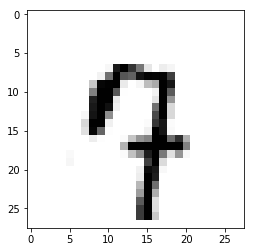

In [14]:
plt.imshow(
    mnist.test.images[r:r + 1].reshape(28, 28), 
    cmap='Greys', interpolation='nearest'
)
plt.show()